**Deep Learning**

**Practice 3.1 - VAE**

**Marcelo Ferrer - Aymen Merchaoui**


## 1. Imports, declarations and configuration

In this section we define the necessary imports, declarations and configuration to run the application. 

In [1]:
# Verify that GPU is active
import tensorflow as tf

gpu_active = tf.config.list_physical_devices('GPU')

if (len(gpu_active) == 0):
    print("NO GPU ACTIVE!!!")
else:
    print("Using GPU")

Using GPU


In [2]:
import numpy as np
import glob, os
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.utils import plot_model

In [3]:
# Disable eager execution (eager execution executes TensorFlow operations immediately)
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [4]:
# Mat plot workaround
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Load the images

In [5]:
DATA_FOLDER = "dataset/img_align_celeba/"
WEIGHTS_FOLDER = 'dataset/weights/'

if not os.path.exists(WEIGHTS_FOLDER):
    os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
    os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

filenames = np.array(glob.glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 202599


In [6]:
# TODO try 64, 128, 256?
INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 256 # Size of the batch
Z_DIM = 200 # Dimension of the latent vector (z)

# Normalization from 0 to 1
data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
    target_size = INPUT_DIM[:2],
    batch_size = BATCH_SIZE,
    shuffle = True,
    class_mode = 'input',
    subset = 'training'
    )

Found 202599 images belonging to 1 classes.


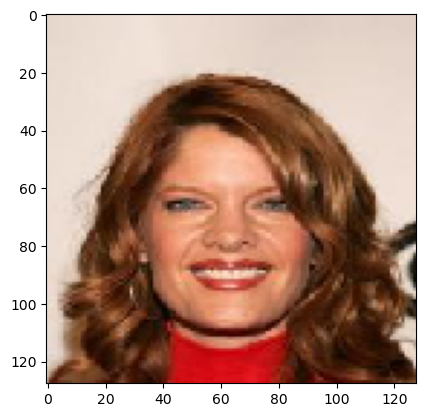

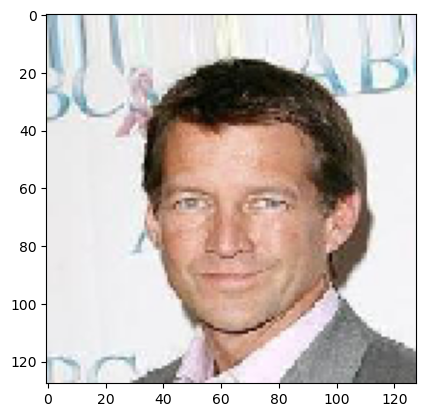

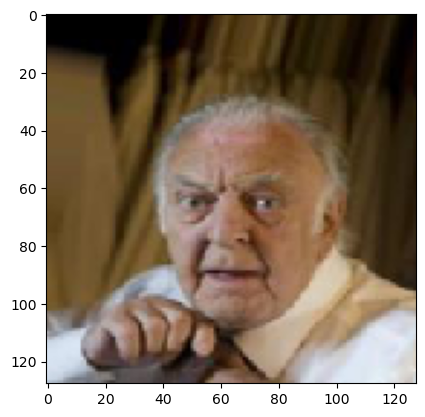

In [7]:
# Display some example images
batch = data_flow.next()
for i in range(0,3):
    image = batch[0][i]
    plt.imshow(image)
    plt.show()

In [8]:
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, conv_strides):
  
    # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
    # BatchNormalization and Dropout.
    # Otherwise, the names of above mentioned layers in the model 
    # would be inconsistent
    global K
    K.clear_session()
    
    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    encoder_input = Input(shape = input_dim, name = 'encoder_input')
    x = encoder_input

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2D(filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'encoder_conv_' + str(i)
            )(x)

        x = LeakyReLU()(x)
        
    # Required for reshaping latent vector while building Decoder
    shape_before_flattening = K.int_shape(x)[1:] 
    
    x = Flatten()(x)
    mean_mu = Dense(output_dim, name = 'mu')(x)
    log_var = Dense(output_dim, name = 'log_var')(x)

    # Defining a function for sampling
    def sampling(args):
        mean_mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
        return mean_mu + K.exp(log_var/2)*epsilon   

    # Using a Keras Lambda Layer to include the sampling function as a layer in the model
    encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])

    return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)

# Creates the encoder with the size and filters passed in the parameters
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(
    input_dim = INPUT_DIM,
    output_dim = Z_DIM, 
    #conv_filters = [32, 64, 64, 64],
    conv_filters = [16, 32, 32, 32],
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2])

vae_encoder.summary()

plot_model(vae_encoder, show_shapes=True, show_layer_names=True)

# TODO show keras visualizer

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 64, 64, 16)   448         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 16)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 32, 32, 32)   4640        ['leaky_re_lu[0][0]']        

In [9]:
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, conv_strides):

    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

    # To get an exact mirror image of the encoder
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2DTranspose(
            filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'decoder_conv_' + str(i)
            )(x)
        
        # Adding a sigmoid layer at the end to restrict the outputs 
        # between 0 and 1
        if i < n_layers - 1:
            x = LeakyReLU()(x)
        else:
            x = Activation('sigmoid')(x)

    # Define model output
    decoder_output = x

    return decoder_input, decoder_output, Model(decoder_input, decoder_output)

# Generate the decoder, as a backward mirror of the encoder
decoder_input, decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
    shape_before_flattening = vae_shape_before_flattening,
    #conv_filters = [64,64,32,3],        
    conv_filters = [32,32,16,1],
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2]
    )

vae_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 2048)              411648    
                                                                 
 reshape (Reshape)           (None, 8, 8, 32)          0         
                                                                 
 decoder_conv_0 (Conv2DTrans  (None, 16, 16, 32)       9248      
 pose)                                                           
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 decoder_conv_1 (Conv2DTrans  (None, 32, 32, 32)       9248      
 pose)                                                     

In [10]:
# Generate the model with the encoder and the decoder
vae_input = vae_encoder_input
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
vae = Model(vae_input, vae_output)

vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 64, 64, 16)   448         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 16)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 32, 32, 32)   4640        ['leaky_re_lu[0][0]']      

In [11]:
def plot_compare_VAE(images, add_noise=False):
    n_to_show = images.shape[0]

    if add_noise:
        encodings = vae_encoder.predict(images)
        encodings += np.random.normal(0.0, 1.0, size = (n_to_show,200))
        reconst_images = vae_decoder.predict(encodings)
    else:
        reconst_images = vae.predict(images)

    fig = plt.figure(figsize=(12, 3))
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, hspace=0.1, wspace=0.1)

    # TODO try without the gray?

    for i in range(n_to_show):
        #img = images[i].squeeze()
        img = images[i]
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img,cmap='gray')

    for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
        sub.axis('off')
        sub.imshow(img,cmap='gray')
    plt.show()

791/791 [==============================] - 1600s 2s/step - batch: 395.5000 - size: 255.8068 - loss: 395.1860 - r_loss: 0.0345 - kl_loss: 50.3035


c:\Users\marce\miniconda3\envs\gpu_dl\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


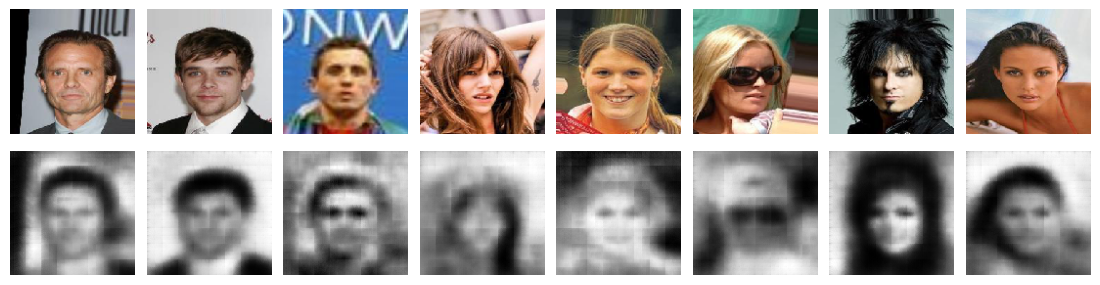

In [12]:
LEARNING_RATE = 0.0005 # Learning rate of the optimizer
N_EPOCHS = 8  # No. of epochs to show advance
N_BLOCKS = 12 # Number of blocks to run (total epochs = N_EPOCHS * N_BLOCKS)
LOSS_FACTOR = 10000

adam_optimizer = Adam(learning_rate = LEARNING_RATE)

# TODO understand loss
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

vae.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

# Takes 8 images to show the results during training
example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:8]

# Just run one epoch and plot the images
vae.fit(data_flow, 
    shuffle=True, 
    epochs = 1, 
    initial_epoch = 0, 
    steps_per_epoch=NUM_IMAGES / BATCH_SIZE)

plot_compare_VAE(example_images) 

Epoch 1/8
791/791 [==============================] - 538s 680ms/step - batch: 395.5000 - size: 255.8068 - loss: 293.0053 - r_loss: 0.0240 - kl_loss: 53.1031
Epoch 2/8
791/791 [==============================] - 152s 192ms/step - batch: 395.5000 - size: 255.8068 - loss: 282.3192 - r_loss: 0.0228 - kl_loss: 53.8753
Epoch 3/8
791/791 [==============================] - 157s 199ms/step - batch: 395.5000 - size: 255.8068 - loss: 277.2312 - r_loss: 0.0223 - kl_loss: 54.5847
Epoch 4/8
791/791 [==============================] - 154s 194ms/step - batch: 395.5000 - size: 255.8068 - loss: 273.9408 - r_loss: 0.0219 - kl_loss: 55.0844
Epoch 5/8
791/791 [==============================] - 153s 193ms/step - batch: 395.5000 - size: 255.8068 - loss: 271.6356 - r_loss: 0.0216 - kl_loss: 55.2580
Epoch 6/8
791/791 [==============================] - 155s 195ms/step - batch: 395.5000 - size: 255.8068 - loss: 270.0106 - r_loss: 0.0215 - kl_loss: 55.3728
Epoch 7/8
791/791 [==============================] - 156s 

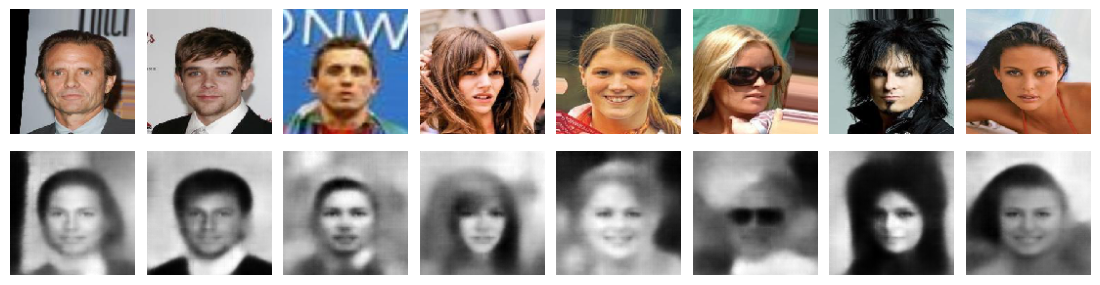

Epoch 1/8
791/791 [==============================] - 152s 193ms/step - batch: 395.5000 - size: 255.8068 - loss: 266.7734 - r_loss: 0.0211 - kl_loss: 55.3657
Epoch 2/8
791/791 [==============================] - 150s 190ms/step - batch: 395.5000 - size: 255.8068 - loss: 266.0219 - r_loss: 0.0211 - kl_loss: 55.3673
Epoch 3/8
791/791 [==============================] - 161s 203ms/step - batch: 395.5000 - size: 255.8068 - loss: 265.4080 - r_loss: 0.0210 - kl_loss: 55.3623
Epoch 4/8
791/791 [==============================] - 165s 209ms/step - batch: 395.5000 - size: 255.8068 - loss: 264.8788 - r_loss: 0.0209 - kl_loss: 55.3966
Epoch 5/8
791/791 [==============================] - 168s 212ms/step - batch: 395.5000 - size: 255.8068 - loss: 264.3798 - r_loss: 0.0209 - kl_loss: 55.4064
Epoch 6/8
791/791 [==============================] - 168s 212ms/step - batch: 395.5000 - size: 255.8068 - loss: 263.9640 - r_loss: 0.0209 - kl_loss: 55.4224
Epoch 7/8
791/791 [==============================] - 170s 

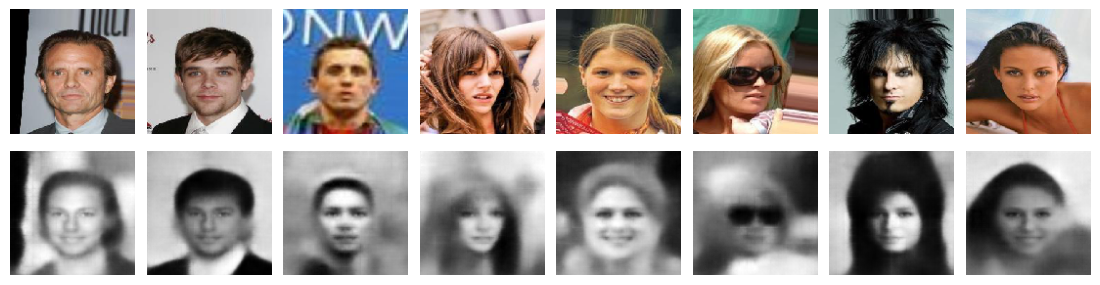

Epoch 1/8
791/791 [==============================] - 178s 225ms/step - batch: 395.5000 - size: 255.8068 - loss: 262.9410 - r_loss: 0.0208 - kl_loss: 55.4227
Epoch 2/8
791/791 [==============================] - 167s 210ms/step - batch: 395.5000 - size: 255.8068 - loss: 262.6729 - r_loss: 0.0207 - kl_loss: 55.4244
Epoch 3/8
791/791 [==============================] - 169s 213ms/step - batch: 395.5000 - size: 255.8068 - loss: 262.4035 - r_loss: 0.0207 - kl_loss: 55.4001
Epoch 4/8
791/791 [==============================] - 177s 224ms/step - batch: 395.5000 - size: 255.8068 - loss: 262.1818 - r_loss: 0.0207 - kl_loss: 55.4200
Epoch 5/8
791/791 [==============================] - 167s 211ms/step - batch: 395.5000 - size: 255.8068 - loss: 262.0021 - r_loss: 0.0207 - kl_loss: 55.3929
Epoch 6/8
791/791 [==============================] - 153s 194ms/step - batch: 395.5000 - size: 255.8068 - loss: 261.7715 - r_loss: 0.0206 - kl_loss: 55.3705
Epoch 7/8
791/791 [==============================] - 155s 

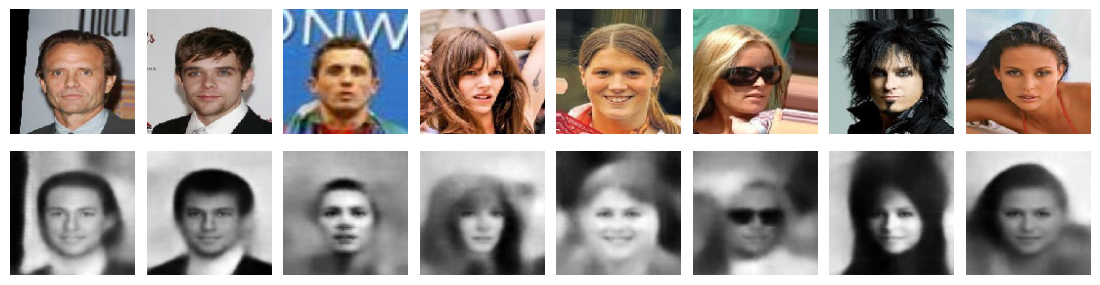

Epoch 1/8
791/791 [==============================] - 154s 195ms/step - batch: 395.5000 - size: 255.8068 - loss: 261.3103 - r_loss: 0.0206 - kl_loss: 55.3816
Epoch 2/8
791/791 [==============================] - 152s 192ms/step - batch: 395.5000 - size: 255.8068 - loss: 261.1115 - r_loss: 0.0206 - kl_loss: 55.3324
Epoch 3/8
791/791 [==============================] - 160s 202ms/step - batch: 395.5000 - size: 255.8068 - loss: 261.0210 - r_loss: 0.0206 - kl_loss: 55.3582
Epoch 4/8
791/791 [==============================] - 151s 191ms/step - batch: 395.5000 - size: 255.8068 - loss: 260.8676 - r_loss: 0.0206 - kl_loss: 55.3468
Epoch 5/8
791/791 [==============================] - 154s 195ms/step - batch: 395.5000 - size: 255.8068 - loss: 260.7450 - r_loss: 0.0205 - kl_loss: 55.3416
Epoch 6/8
791/791 [==============================] - 154s 194ms/step - batch: 395.5000 - size: 255.8068 - loss: 260.6289 - r_loss: 0.0205 - kl_loss: 55.3569
Epoch 7/8
791/791 [==============================] - 155s 

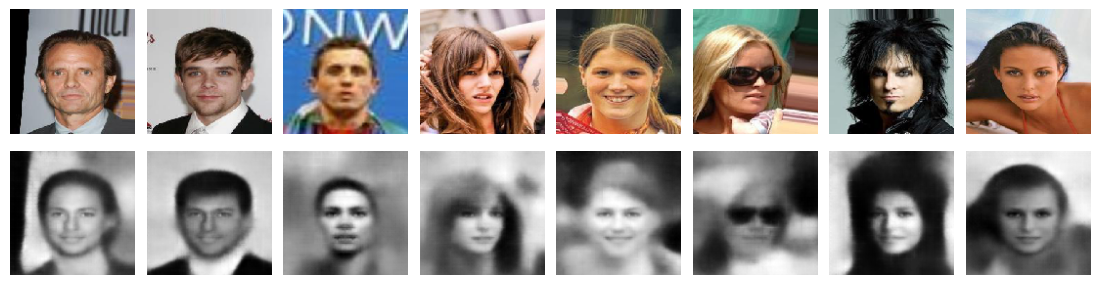

Epoch 1/8
791/791 [==============================] - 156s 197ms/step - batch: 395.5000 - size: 255.8068 - loss: 260.3094 - r_loss: 0.0205 - kl_loss: 55.2910
Epoch 2/8
791/791 [==============================] - 165s 208ms/step - batch: 395.5000 - size: 255.8068 - loss: 260.2673 - r_loss: 0.0205 - kl_loss: 55.3345
Epoch 3/8
791/791 [==============================] - 167s 211ms/step - batch: 395.5000 - size: 255.8068 - loss: 260.1286 - r_loss: 0.0205 - kl_loss: 55.3218
Epoch 4/8
791/791 [==============================] - 168s 213ms/step - batch: 395.5000 - size: 255.8068 - loss: 260.0570 - r_loss: 0.0205 - kl_loss: 55.3152
Epoch 5/8
791/791 [==============================] - 163s 206ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.9785 - r_loss: 0.0205 - kl_loss: 55.3069
Epoch 6/8
791/791 [==============================] - 178s 225ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.9210 - r_loss: 0.0205 - kl_loss: 55.2817
Epoch 7/8
791/791 [==============================] - 166s 

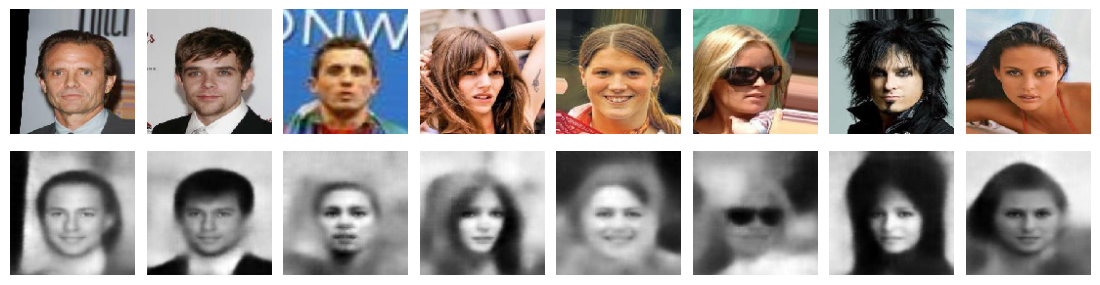

Epoch 1/8
791/791 [==============================] - 173s 218ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.7227 - r_loss: 0.0204 - kl_loss: 55.3002
Epoch 2/8
791/791 [==============================] - 168s 212ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.6588 - r_loss: 0.0204 - kl_loss: 55.3058
Epoch 3/8
791/791 [==============================] - 167s 211ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.6207 - r_loss: 0.0204 - kl_loss: 55.3067
Epoch 4/8
791/791 [==============================] - 173s 219ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.5295 - r_loss: 0.0204 - kl_loss: 55.2940
Epoch 5/8
791/791 [==============================] - 164s 206ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.4483 - r_loss: 0.0204 - kl_loss: 55.2763
Epoch 6/8
791/791 [==============================] - 155s 196ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.4254 - r_loss: 0.0204 - kl_loss: 55.2602
Epoch 7/8
791/791 [==============================] - 156s 

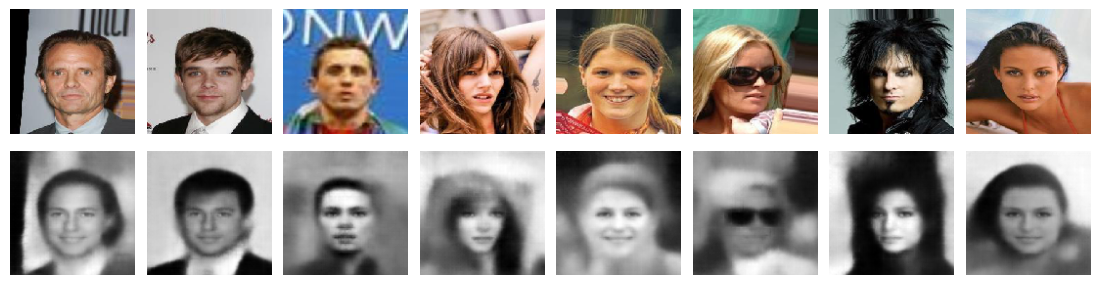

Epoch 1/8
791/791 [==============================] - 156s 198ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.2674 - r_loss: 0.0204 - kl_loss: 55.2562
Epoch 2/8
791/791 [==============================] - 155s 196ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.2353 - r_loss: 0.0204 - kl_loss: 55.2646
Epoch 3/8
791/791 [==============================] - 151s 191ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.1889 - r_loss: 0.0204 - kl_loss: 55.2761
Epoch 4/8
791/791 [==============================] - 153s 194ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.0843 - r_loss: 0.0204 - kl_loss: 55.2438
Epoch 5/8
791/791 [==============================] - 155s 196ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.0964 - r_loss: 0.0204 - kl_loss: 55.2559
Epoch 6/8
791/791 [==============================] - 154s 194ms/step - batch: 395.5000 - size: 255.8068 - loss: 259.0418 - r_loss: 0.0204 - kl_loss: 55.2520
Epoch 7/8
791/791 [==============================] - 155s 

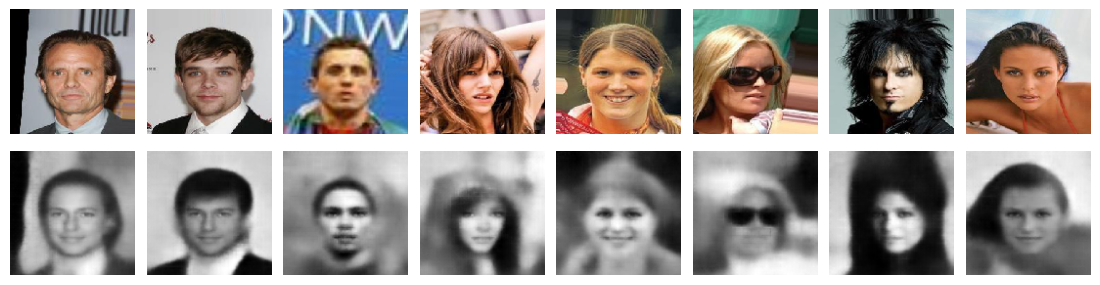

Epoch 1/8
791/791 [==============================] - 161s 203ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.9235 - r_loss: 0.0204 - kl_loss: 55.2550
Epoch 2/8
791/791 [==============================] - 167s 211ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.8708 - r_loss: 0.0204 - kl_loss: 55.2421
Epoch 3/8
791/791 [==============================] - 169s 213ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.8071 - r_loss: 0.0204 - kl_loss: 55.2238
Epoch 4/8
791/791 [==============================] - 170s 214ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.7961 - r_loss: 0.0204 - kl_loss: 55.2340
Epoch 5/8
791/791 [==============================] - 164s 207ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.7789 - r_loss: 0.0204 - kl_loss: 55.2246
Epoch 6/8
791/791 [==============================] - 171s 215ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.7327 - r_loss: 0.0204 - kl_loss: 55.2161
Epoch 7/8
791/791 [==============================] - 168s 

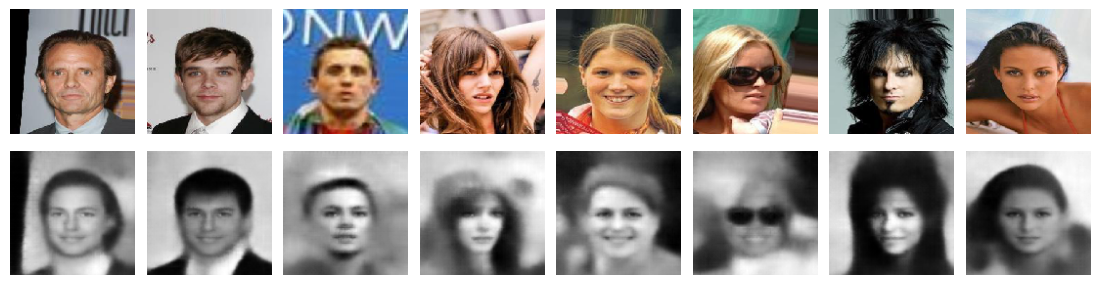

Epoch 1/8
791/791 [==============================] - 169s 213ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.6486 - r_loss: 0.0203 - kl_loss: 55.2228
Epoch 2/8
791/791 [==============================] - 202s 255ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.6099 - r_loss: 0.0203 - kl_loss: 55.2330
Epoch 3/8
791/791 [==============================] - 165s 209ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.5638 - r_loss: 0.0203 - kl_loss: 55.1737
Epoch 4/8
791/791 [==============================] - 182s 229ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.5856 - r_loss: 0.0203 - kl_loss: 55.2210
Epoch 5/8
791/791 [==============================] - 151s 191ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.5384 - r_loss: 0.0203 - kl_loss: 55.2265
Epoch 6/8
791/791 [==============================] - 153s 193ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.5090 - r_loss: 0.0203 - kl_loss: 55.1994
Epoch 7/8
791/791 [==============================] - 156s 

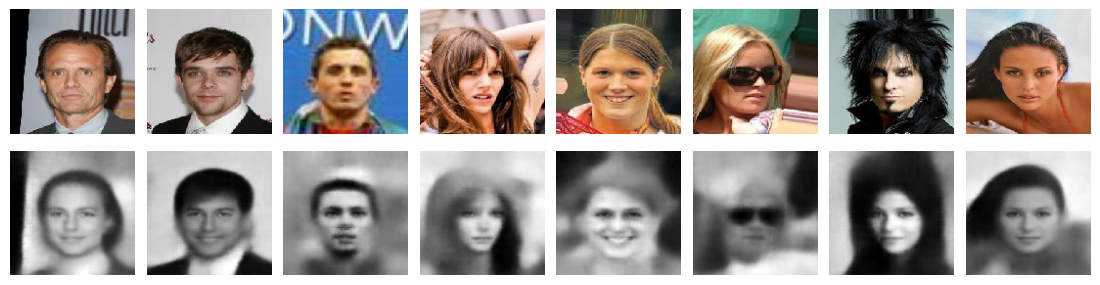

Epoch 1/8
791/791 [==============================] - 157s 199ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.4386 - r_loss: 0.0203 - kl_loss: 55.2087
Epoch 2/8
791/791 [==============================] - 155s 195ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.3851 - r_loss: 0.0203 - kl_loss: 55.2002
Epoch 3/8
791/791 [==============================] - 156s 197ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.3932 - r_loss: 0.0203 - kl_loss: 55.2140
Epoch 4/8
791/791 [==============================] - 155s 196ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.3548 - r_loss: 0.0203 - kl_loss: 55.1861
Epoch 5/8
791/791 [==============================] - 155s 196ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.3004 - r_loss: 0.0203 - kl_loss: 55.1687
Epoch 6/8
791/791 [==============================] - 155s 195ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.3111 - r_loss: 0.0203 - kl_loss: 55.2035
Epoch 7/8
791/791 [==============================] - 163s 

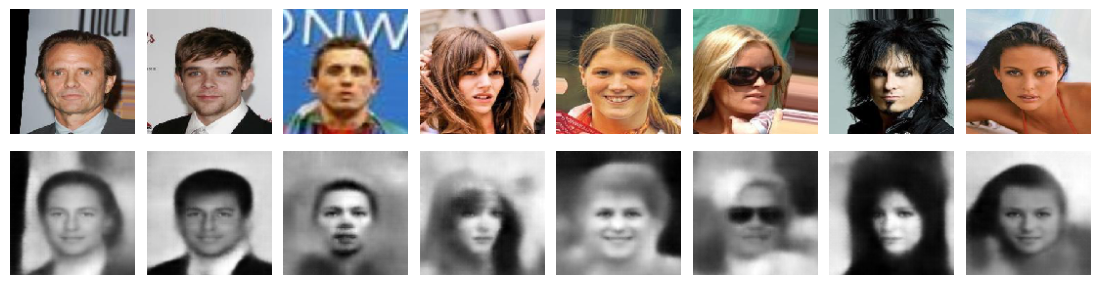

Epoch 1/8
791/791 [==============================] - 210s 265ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.2608 - r_loss: 0.0203 - kl_loss: 55.1895
Epoch 2/8
791/791 [==============================] - 168s 212ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.2093 - r_loss: 0.0203 - kl_loss: 55.1608
Epoch 3/8
791/791 [==============================] - 168s 212ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.2086 - r_loss: 0.0203 - kl_loss: 55.1999
Epoch 4/8
791/791 [==============================] - 192s 242ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.1753 - r_loss: 0.0203 - kl_loss: 55.1961
Epoch 5/8
791/791 [==============================] - 168s 212ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.1557 - r_loss: 0.0203 - kl_loss: 55.1817
Epoch 6/8
791/791 [==============================] - 168s 212ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.1354 - r_loss: 0.0203 - kl_loss: 55.1804
Epoch 7/8
791/791 [==============================] - 168s 

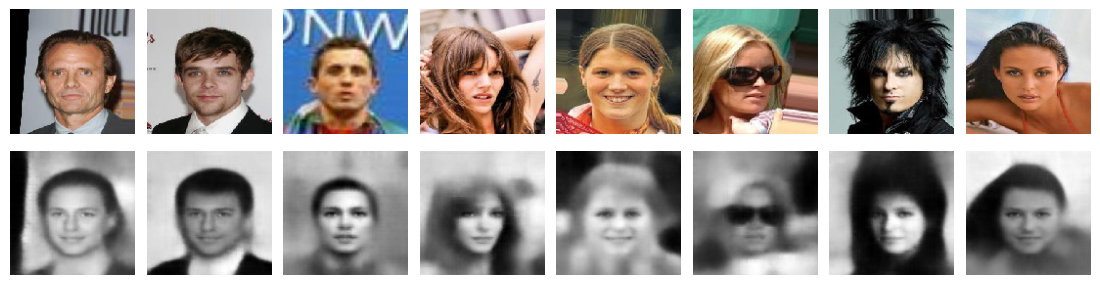

Epoch 1/8
791/791 [==============================] - 170s 214ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.0459 - r_loss: 0.0203 - kl_loss: 55.1661
Epoch 2/8
791/791 [==============================] - 165s 208ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.0698 - r_loss: 0.0203 - kl_loss: 55.1871
Epoch 3/8
791/791 [==============================] - 163s 206ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.0261 - r_loss: 0.0203 - kl_loss: 55.1523
Epoch 4/8
791/791 [==============================] - 156s 197ms/step - batch: 395.5000 - size: 255.8068 - loss: 257.9951 - r_loss: 0.0203 - kl_loss: 55.1463
Epoch 5/8
791/791 [==============================] - 158s 200ms/step - batch: 395.5000 - size: 255.8068 - loss: 258.0164 - r_loss: 0.0203 - kl_loss: 55.1671
Epoch 6/8
791/791 [==============================] - 154s 195ms/step - batch: 395.5000 - size: 255.8068 - loss: 257.9907 - r_loss: 0.0203 - kl_loss: 55.1630
Epoch 7/8
791/791 [==============================] - 161s 

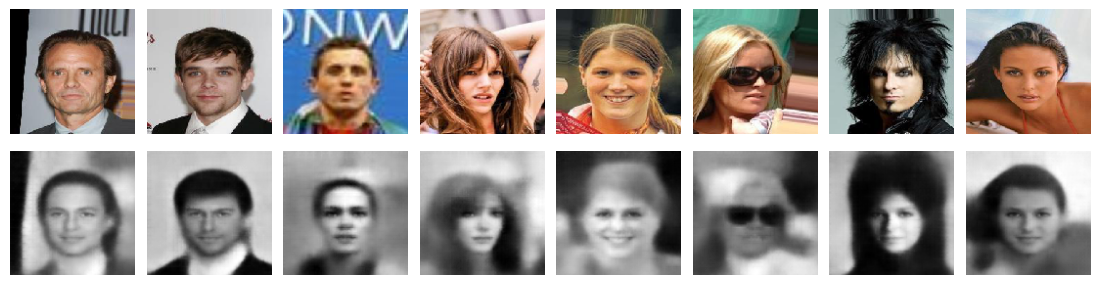

In [13]:
# For each block train the model for a number of epochs and show the partial images
for i in range(N_BLOCKS):
    vae.fit(data_flow, 
        shuffle=True, 
        epochs = N_EPOCHS, 
        initial_epoch = 0, 
        steps_per_epoch=NUM_IMAGES / BATCH_SIZE)
    plot_compare_VAE(example_images) 

In [14]:
# TODO try different learning rate?

In [15]:
# TODO try different Conv?